# 🏆 문제[예선]
Q. 우리나라의 쓰레기 배출량은 매년 증가하고 있습니다. 특히 재활용 쓰레기 중 플라스틱류는 2020년 3월 868톤으로(단위: 톤/일) 2019년 839톤보다 9.1% 증가하였습니다. 이러한 상황에서 AI를 이용한 쓰레기 분리 수거를 통해 점점 늘어나는 쓰레기 배출량에 효과적으로 대비하고자합니다. 주어진 쓰레기 이미지들에 머신러닝 기법인 분류(claasification)기법을 적용하여, 분리수거를 수행해보세요!

## 📝 데이터 설명

- 총 데이터 수: 2527장 \
image data shape : 3x256x256 (RGB channel, height, width)
- 훈련 데이터(Train Data): 1516개의 이미지파일

- 검증 데이터(Validation data): 506개의 이미지파일

- 평가 데이터(Test Data): 505개의 이미지파일

- 목표: 평가데이터 셋 분류 성능 평가

- 피처 상세 설명: 평가 데이터의 정답은 주어지지 않습니다. 정답 클래스는 6개입니다. 클래스 : 판지(cardboard), 유리(glass), 금속(metal), 종이(paper), 플라스틱(plastic), 일반쓰레기(trash) \

- 평가기준 : test data accuracy

## 🔔 구글 드라이브 마운트
- 아래 코드 셀을 실행하시거나 왼쪽 파일 탭에서 드라이브 마운트 설정을 하시면 됩니다! 

In [ ]:
# Google drive mount 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# 🔔 패키지 import

필요한 패키지가 있다면 추가로 import하시면 됩니다.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 할당

# Colab torch, gpu 확인
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))


Torch version:1.9.0+cu102
cuda version: 10.2
cudnn version:7605


# 🔔 할당 받은 GPU확인
- 딥러닝을 효율적으로 돌리기 위해서는 GPU가 필요합니다!
- 아래 셀을 실행하시면 google colab에서 제공해주는 GPU를 확인할 수 있습니다 :)

In [ ]:
!nvidia-smi

Sat Sep 11 04:29:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 🔔 데이터 불러오기 & Mini batch 분할
X_train : model을 학습할 훈련 데이터입니다. \
Y_train : 훈련 데이터의 정답 데이터입니다. \
X_val : model 성능을 검증하는 검증 데이터입니다. \
Y_val : 검증 데이터의 정답 데이터입니다. \
X_test : 최종 제출할 prediction 결과에 사용할 test 데이터입니다. 정답 데이터는 따로 제공하지 않습니다.

- 데이터는 미리 split하여 train와 valid, test로 나누었습니다
- 이번 딥러닝 모델 학습은 mini batch 단위로 진행하기위해,
 Dataloader에서 BATCH_SIZE를 조절하여 사용합니다!


***📢 kaggle에서 Dataset을 다운 받고 google colab project 폴더에 위치시켜두세요***

#### 🧪 BATCH SIZE를 조절해보세요!

In [ ]:
"""
1. BATCH SIZE를 조절해보세요!
- model이 한 번 학습할때 사용되는 data수 입니다
"""
BATCH_SIZE = 16

In [ ]:
# Load data path
ROOT = "/content/drive/MyDrive"
DIR = "Colab Notebooks/Dataset"  # data 폴더와 ipynb 파일이 위치한 폴더명을 적으세요.
PATH = os.path.join(ROOT, DIR)
os.chdir(PATH)  # 현재 프로젝트 PATH로 이동

# train, validation은 npy형태로 제공됩니다.
X_train = np.load("Dataset/Train/X_train.npy")
Y_train = np.load("Dataset/Train/Y_train.npy")
X_val = np.load("Dataset/Valid/X_val.npy")
Y_val = np.load("Dataset/Valid/Y_val.npy")
X_test = np.load("Dataset/Test/X_test.npy")  # 최종 제출할 prediction 결과에 사용할 데이터입니다.

# numpy to torch
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).long()
X_test = torch.from_numpy(X_test).float()  

# Print data info
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Train_Loader : mini batch 분할
train = TensorDataset(X_train, Y_train) 
val = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)  

X_train shape: torch.Size([1516, 3, 256, 256])
X_val shape: torch.Size([506, 3, 256, 256])


In [ ]:

BATCH_SIZE = 256
train_loader = DataLoader(train,batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
x_train

tensor([[[ 0.8275,  0.8275,  0.8275,  ..., -0.0039, -0.4667, -0.4824],
         [ 0.8275,  0.8275,  0.8275,  ...,  0.3569, -0.2157, -0.4902],
         [ 0.8353,  0.8353,  0.8353,  ...,  0.5608,  0.2627, -0.3412],
         ...,
         [ 0.7569,  0.7569,  0.7569,  ...,  0.4824,  0.4667,  0.4588],
         [ 0.7569,  0.7569,  0.7569,  ...,  0.4824,  0.4745,  0.4667],
         [ 0.7569,  0.7569,  0.7569,  ...,  0.4745,  0.4745,  0.4667]],

        [[ 0.6235,  0.6235,  0.6235,  ..., -0.1451, -0.6078, -0.6235],
         [ 0.6235,  0.6235,  0.6235,  ...,  0.2157, -0.3569, -0.6314],
         [ 0.6314,  0.6314,  0.6314,  ...,  0.4196,  0.1216, -0.4824],
         ...,
         [ 0.5451,  0.5451,  0.5451,  ...,  0.3412,  0.3333,  0.3255],
         [ 0.5451,  0.5451,  0.5451,  ...,  0.3412,  0.3333,  0.3333],
         [ 0.5451,  0.5451,  0.5451,  ...,  0.3333,  0.3333,  0.3333]],

        [[ 0.5216,  0.5216,  0.5216,  ..., -0.2549, -0.7176, -0.7333],
         [ 0.5216,  0.5216,  0.5216,  ...,  0

### 🔔데이터 시각화
- 실제 data를 한번 확인해보세요!

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Label: cardboard (Class num : 0)


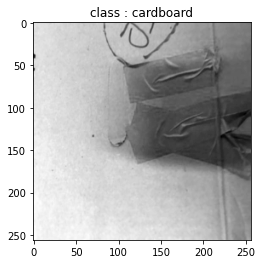

Label: cardboard (Class num : 0)


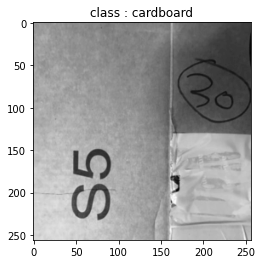

Label: cardboard (Class num : 0)


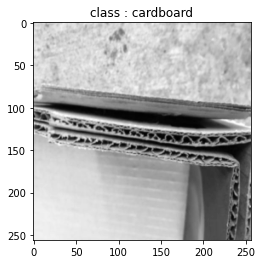

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


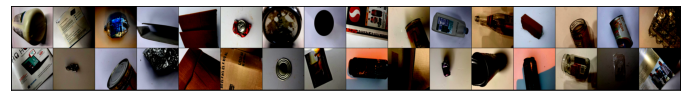

In [ ]:
# class label 
# classes 변수는 바꾸시지 마세요
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  # 0 : cardboard, 1 : glass, 2 : metal, 3 : paper, 4 : plastic, 5 : trash
print(classes)

def show_image(img, img_label):
    print("Label:", classes[img_label], "(Class num : " + str(img_label.numpy()) + ")")
    plt.imshow(img[1, :, :], cmap="gray")  # gray image
    plt.title("class : {}".format(classes[img_label]))
    plt.show()


for i, (images, labels) in enumerate(train_loader):
    image_index = random.randint(0, BATCH_SIZE)  # BATCH_SIZE : 32
    show_image(images[image_index], labels[image_index])
    if (i+1) == 3:  # 3개의 image 출력
        break

# batch 개수 만큼 이미지를 시각화
def show_batch(DataLoader):
    for images, labels in DataLoader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break

show_batch(train_loader)

### 🔔 커스텀 함수
- accuracy를 계산하는 간단한 함수입니다!
- 모델의 성능을 평가하는 방법 중 하나로 valid accuracy를 통해 모델을 평가합니다

In [ ]:
# accuracy 계산
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# 📝 분류 문제 해결하기 : 딥러닝 model
##### ***이제 본격적으로 학습을 시작해봅시다!***
##### 예선 코드에서는 image data처리에 특화된 Convolutional neural network model 중 AlexNet과 ResNet만 제공됩니다.

1. model : AlexNet \
num_layer : 8 layers \
2. model : ResNet18 \
num_layer : 18 layers


- convolution의 channel 수와 layer 개수 등의 parameter들을 조절하면서 성능을 높여보세요! [shape을 잘 고려해보세요] \

- 모델을 바꾸셔도 됩니다. 또한 다른 CNN 기반 model 사용하셔도 됩니다 \
 : 너무 깊은 모델은 학습 속도상 권장하지 않습니다..! \
 학습되는 시간을 잘 고려해서 모델을 사용하세요. \
 pytorch에서 제공하는 CNN module들이 있습니다.

- 모델에 대한 더 깊은 이해를 원하시면 다음 리뷰를 참고하시면 좋을 거 같습니다! \

📢 참고 자료

AlexNet : https://deep-learning-study.tistory.com/376

ResNet : https://velog.io/@kangtae/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0-Deep-Residual-Learning-for-Image-Recognition-ResNet

CNN 이해하기 : 
1. https://halfundecided.medium.com/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-cnn-convolutional-neural-networks-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-836869f88375
2. http://taewan.kim/post/cnn/



In [ ]:
# CNN model
# 예선 코드에서 baseline으로는 AlexNet을 제공하고 advanced model로 ResNet18을 제공합니다
"""
추가로 다른 CNN model을 이 코드 셀에서 구현하셔서 이용하셔도 됩니다..!
단, 너무 깊은 model은 권장하지 않습니다.
모델 학습 시간을 잘 고려해서 사용해보세요!
"""
class AlexNet(nn.Module):
    def __init__(self, num_classes=6):  # num_classes : class 개수
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.maxpool1 = nn.MaxPool2d(3, 2)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(3, 2)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(3, 2)
        self.lin1 = nn.Linear(6*6*256, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool3(x)
        x = x.flatten(1)
        x = F.relu(F.dropout2d(self.lin1(x), p=0.2))
        x = F.relu(F.dropout2d(self.lin2(x), p=0.2))
        out = F.relu(self.lin3(x))

        return out
    

# BasicBlock
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# resnet18
class ResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(32, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(64, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(128, num_blocks=2, stride=2)
        self.lin = nn.Linear(2048, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)   # num_block으로 BasicBlock수 결정, num_blocks = 2, strides = 1 이면 strides=[1, 1]
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.lin(out)
        return out

# model 확인 : 모델의 shape을 간단하게 출력
model = AlexNet()
print(model)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=9216, out_features=4096, bias=True)
  (lin2): Linear(in_features=4096, out_features=4096, bias=True)
  (lin3): Linear(in_features=4096, out

### 🧪 Training
- learning_rate(lr), weight_decay, epoch등 hyper parameter를 조절해가면서 training을 진행해보세요! \
- optimizer를 변경하셔도 됩니다.

In [ ]:
# hyperparameter
"""
2. hyperparameter를 바꿔봅시다!
- 처음에 제공되는 값을 임의로 설정한 값입니다. 바꾸시고 돌리시면 됩니다!
"""
# learning rate : 모델의 학습 속도를 조절합니다. 
lr = 0.01

# weight_decay : L2 regularization으로 모델의 overfitting을 방지합니다
weight_decay = 0.01

# epoch : 전체 dataset을 몇번 학습 시킬지 조절해보세요
epochs = 30

# model 선택 : AlexNet, ResNet
net = AlexNet().to(device)

# optimizer 선택 (gradient descent : model update 방법): SGD, Adam, RMSProp
# pytorch에서 제공하는 optimizer : https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
#optimizer = optim.Adam(net.parameters(),lr = lr)

# learning rate decay : 학습 도중 learning rate를 조절하는 technique 
# pytorch에서 제공하는 learning rate decay : https://pytorch.org/docs/stable/optim.html
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)  # epoch마다 x0.999 만큼 lr 감소

In [ ]:
# hyperparameter
"""
2. hyperparameter를 바꿔봅시다!
- 처음에 제공되는 값을 임의로 설정한 값입니다. 바꾸시고 돌리시면 됩니다!
"""
# learning rate : 모델의 학습 속도를 조절합니다. 
lr = 0.001

# weight_decay : L2 regularization으로 모델의 overfitting을 방지합니다
weight_decay = 0.001

# epoch : 전체 dataset을 몇번 학습 시킬지 조절해보세요
epochs = 30

# model 선택 : AlexNet, ResNet

# optimizer 선택 (gradient descent : model update 방법): SGD, Adam, RMSProp
# pytorch에서 제공하는 optimizer : https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
#optimizer = optim.Adam(net.parameters(),lr = lr)

# learning rate decay : 학습 도중 learning rate를 조절하는 technique 
# pytorch에서 제공하는 learning rate decay : https://pytorch.org/docs/stable/optim.html


lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)  # epoch마다 x0.999 만큼 lr 감소

In [ ]:
# training
train_loss_list = []
val_loss_list = []
train_correct_list = []
val_correct_list = []
result = {}

# loss 함수
criterion = nn.CrossEntropyLoss() 

for epoch in range(1,30 + 1):
    net.train()
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    start_time = time.time()  # epoch당 걸리는 시간 계산

    # training
    for batch_idx, (input, label) in enumerate(train_loader):
        input, label = input.to(device), label.to(device)

        optimizer.zero_grad()
        out = net(input)
        loss = criterion(out, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_acc = accuracy(out, label)
        train_correct += train_acc

    # validation
    with torch.no_grad():
        for batch_idx, (val_input, val_label) in enumerate(val_loader): 
            net.eval()
            val_input, val_label = val_input.to(device), val_label.to(device)
            val_out = net(val_input)
            loss = criterion(val_out, val_label)
            val_loss += loss.item()
            val_acc = accuracy(val_out, val_label)
            val_correct += val_acc
    

    print("[=] EPOCH [{:}/{:} TIME [{:.3}s]".format(epoch, epochs, time.time()-start_time) + \
          " | TRAIN_LOSS [{:.3}] TRAIN_ACC [{:.3}] VAL_LOSS [{:.3}] VAL_ACC [{:.3}] ".format(
              train_loss / len(train_loader), train_correct / len(train_loader), val_loss / len(val_loader), val_correct / len(val_loader)))
    train_loss_list.append(train_loss / len(train_loader))
    train_correct_list.append(train_correct.item() / len(train_loader))
    val_loss_list.append(val_loss / len(val_loader))
    val_correct_list.append(val_correct.item() / len(val_loader))
    lr_scheduler.step()  # learning rate schedular step

# 결과 저장
result['train_loss'] = train_loss_list
result['train_acc'] = train_correct_list
result['val_loss'] = val_loss_list
result['val_acc'] = val_correct_list
total_result = []
total_result.append(result)


[=] EPOCH [1/30 TIME [11.7s] | TRAIN_LOSS [0.29] TRAIN_ACC [0.912] VAL_LOSS [1.53] VAL_ACC [0.584] 
[=] EPOCH [2/30 TIME [11.6s] | TRAIN_LOSS [0.313] TRAIN_ACC [0.901] VAL_LOSS [1.74] VAL_ACC [0.57] 
[=] EPOCH [3/30 TIME [11.6s] | TRAIN_LOSS [0.447] TRAIN_ACC [0.857] VAL_LOSS [1.74] VAL_ACC [0.515] 
[=] EPOCH [4/30 TIME [11.6s] | TRAIN_LOSS [0.325] TRAIN_ACC [0.898] VAL_LOSS [1.44] VAL_ACC [0.599] 
[=] EPOCH [5/30 TIME [11.6s] | TRAIN_LOSS [0.26] TRAIN_ACC [0.916] VAL_LOSS [1.65] VAL_ACC [0.523] 
[=] EPOCH [6/30 TIME [11.6s] | TRAIN_LOSS [0.399] TRAIN_ACC [0.866] VAL_LOSS [1.4] VAL_ACC [0.6] 
[=] EPOCH [7/30 TIME [11.6s] | TRAIN_LOSS [0.325] TRAIN_ACC [0.891] VAL_LOSS [1.47] VAL_ACC [0.56] 
[=] EPOCH [8/30 TIME [11.7s] | TRAIN_LOSS [0.274] TRAIN_ACC [0.916] VAL_LOSS [1.25] VAL_ACC [0.603] 
[=] EPOCH [9/30 TIME [11.6s] | TRAIN_LOSS [0.319] TRAIN_ACC [0.895] VAL_LOSS [1.42] VAL_ACC [0.591] 
[=] EPOCH [10/30 TIME [11.6s] | TRAIN_LOSS [0.251] TRAIN_ACC [0.916] VAL_LOSS [1.67] VAL_ACC [0.57

In [ ]:
train

### 🔔 학습 결과 시각화
- 학습한 결과인 accuracy, loss를 plot으로 그려 확인해보세요!
- 밑에 코드를 실행하시면 plot을 확인할 수 있습니다

***accuracy가 진동하지 않고 잘 올라가는지, 또한 loss가 잘 떨어지는지 확인해보세요!***

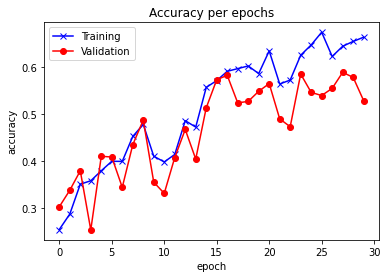

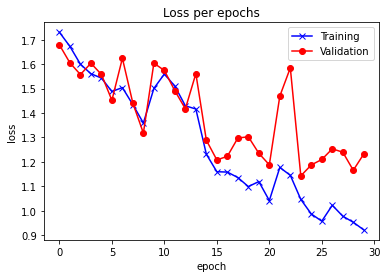

In [ ]:
def plot_acc(total_result):
    train_acc = [x['train_acc'] for x in total_result]
    val_acc = [x['val_acc'] for x in total_result]
    plt.plot(*train_acc, '-bx')
    plt.plot(*val_acc, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy per epochs');
    plt.show()


def plot_loss(total_result):
    train_loss = [x.get('train_loss') for x in total_result]
    val_loss = [x['val_loss'] for x in total_result]
    plt.plot(*train_loss, '-bx')
    plt.plot(*val_loss, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss per epochs');
    plt.show()

plot_acc(total_result)
plot_loss(total_result)

In [ ]:
# test 결과 확인
"""
주의) X_test data는 순서를 섞지마세요!
      이 code cell은 수정하지마세요
"""
def predict_test(img, model):
    x = img.to(device)
    model.eval()
    y = model(x)
    _, pred  = torch.max(y, dim=1)

    return pred

# test data shape
print(X_test.shape)

# GPU memory 제한으로 하나씩 X test data 예측 후 list로 저장
preds = []
for i in range(len(X_test)):
    pred = predict_test(X_test[i:i+1], net)
    preds.append(pred.item())

print(len(preds))

# DataFrame 
# id 추가
id = [i for i in range(len(X_test))]
test_preds = {'id': id, 'label': preds}

torch.Size([505, 3, 256, 256])
505


### 🥇 Prediction 결과제출

- 수고하셨습니다!!!
- X_test 예측 결과를 아래 cell을 실행해서 csv를 생성하세요
- output 폴더에 생성된 '(팀 명)_(timestampe).csv'를 kaggle competition 리더보드에 제출해주시면 됩니다!

In [ ]:
from datetime import datetime
timestamp = datetime.today().strftime("%Y%m%d%H%M%S")  # ex) timestamp 20210911131000

# Make output directory : test data 결과 파일 저장 경로 생성
SAVE_PATH = os.path.join(PATH, "output")
if not os.path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
else:
  pass

# Make submission file
"""
3. 반드시 팀명을 바꾸고 제출해주세요
"""
team = "해피크리에이터"

sub = pd.DataFrame(test_preds)
sub.to_csv(os.path.join(SAVE_PATH, f"./{team}_{timestamp}.csv"), index=False)